# TRAINING MODELS HERE

In [65]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [66]:
# --- 1. Your Custom Dataset class for DataFrame-based image loading ---

class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row['class'].lower()]
        if self.transform:
            image = self.transform(image)
        return image, label

In [67]:
# --- 2. Define transforms ---

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   # Random horizontal flip augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [68]:
# --- 3. Create Dataset and DataLoader instances from your DataFrames ---

# Assume train_df and val_df are your pandas DataFrames with columns 'filename' and 'class'
# Assume train_img_dir is the path to the folder containing all training images

train_dataset = RockPaperScissorsDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = RockPaperScissorsDataset(val_df, train_img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [69]:
# --- 4. Load pretrained ResNet50 and modify the final layer ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes: rock, paper, scissors

model = model.to(device)

/home/cconcha/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cconcha/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# --- 5. Define loss function and optimizer ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train final layer

Epoch [1/20] Loss: 1.2046 Validation Accuracy: 0.3500
Epoch [2/20] Loss: 1.0821 Validation Accuracy: 0.3000
Epoch [3/20] Loss: 0.9888 Validation Accuracy: 0.3833
Epoch [4/20] Loss: 0.9426 Validation Accuracy: 0.4167
Epoch [5/20] Loss: 0.9170 Validation Accuracy: 0.4167
Epoch [6/20] Loss: 0.8890 Validation Accuracy: 0.4000
Epoch [7/20] Loss: 0.8466 Validation Accuracy: 0.4333
Epoch [8/20] Loss: 0.8198 Validation Accuracy: 0.3833
Epoch [9/20] Loss: 0.8397 Validation Accuracy: 0.4000
Epoch [10/20] Loss: 0.7727 Validation Accuracy: 0.4667
Epoch [11/20] Loss: 0.7972 Validation Accuracy: 0.4167
Epoch [12/20] Loss: 0.7221 Validation Accuracy: 0.4500
Epoch [13/20] Loss: 0.7360 Validation Accuracy: 0.4000
Epoch [14/20] Loss: 0.7024 Validation Accuracy: 0.4667
Epoch [15/20] Loss: 0.7011 Validation Accuracy: 0.4667
Epoch [16/20] Loss: 0.6797 Validation Accuracy: 0.4167
Epoch [17/20] Loss: 0.6494 Validation Accuracy: 0.4167
Epoch [18/20] Loss: 0.6640 Validation Accuracy: 0.5000
Epoch [19/20] Loss:

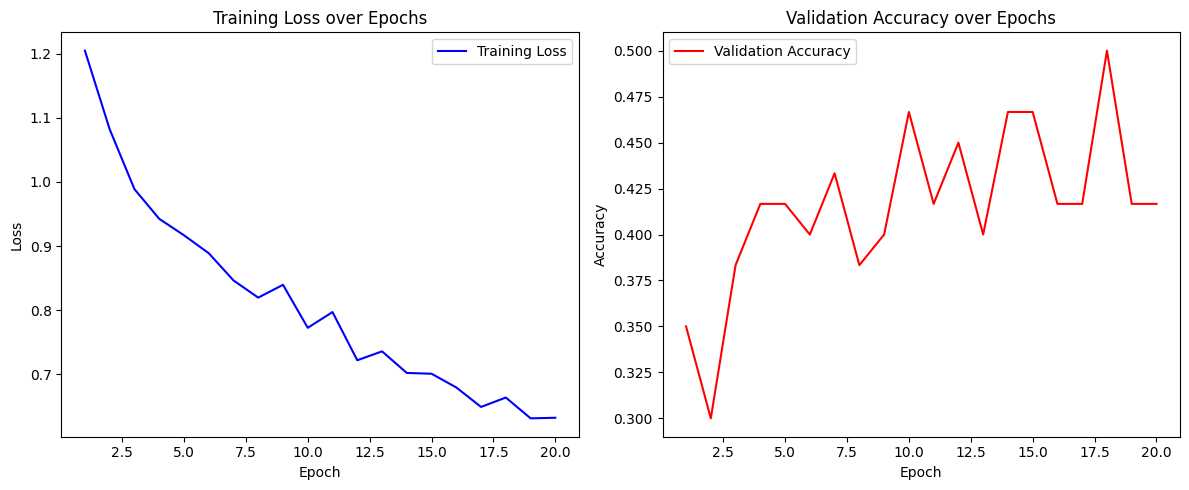

In [72]:
# --- 6. Training and validation loop ---
num_epochs = 20
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Validation Accuracy: {val_acc:.4f}")

print("Training complete.")

# After training, plot learning curves
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Unfreeze some layers to see if validation accuracy improves

In [75]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze some last layers. For ResNet50, there are 10 children layers (conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc).
# Most commonly, you unfreeze the last few blocks, e.g. layer3 and layer4, which correspond to the last convolutional blocks.
for name, child in list(model.named_children())[5:8]:  # layer3, layer4, avgpool (avgpool usually does not have params)
    for param in child.parameters():
        param.requires_grad = True

# Replace the final fully connected layer for your 3 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Make sure the fc layer's params are trainable
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Setup optimizer with only trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # Lower LR for fine-tuning


Epoch [1/20] Loss: 1.0469 Validation Accuracy: 0.4000
Epoch [2/20] Loss: 0.5490 Validation Accuracy: 0.5667
Epoch [3/20] Loss: 0.2913 Validation Accuracy: 0.6167
Epoch [4/20] Loss: 0.1343 Validation Accuracy: 0.7000
Epoch [5/20] Loss: 0.1012 Validation Accuracy: 0.6833
Epoch [6/20] Loss: 0.0589 Validation Accuracy: 0.6000
Epoch [7/20] Loss: 0.0442 Validation Accuracy: 0.6333
Epoch [8/20] Loss: 0.0311 Validation Accuracy: 0.6833
Epoch [9/20] Loss: 0.0215 Validation Accuracy: 0.6500
Epoch [10/20] Loss: 0.0211 Validation Accuracy: 0.6667
Epoch [11/20] Loss: 0.0125 Validation Accuracy: 0.6833
Epoch [12/20] Loss: 0.0203 Validation Accuracy: 0.6500
Epoch [13/20] Loss: 0.0128 Validation Accuracy: 0.6500
Epoch [14/20] Loss: 0.0132 Validation Accuracy: 0.6833
Epoch [15/20] Loss: 0.0117 Validation Accuracy: 0.7000
Epoch [16/20] Loss: 0.0065 Validation Accuracy: 0.7500
Epoch [17/20] Loss: 0.0043 Validation Accuracy: 0.7500
Epoch [18/20] Loss: 0.0202 Validation Accuracy: 0.7500
Epoch [19/20] Loss:

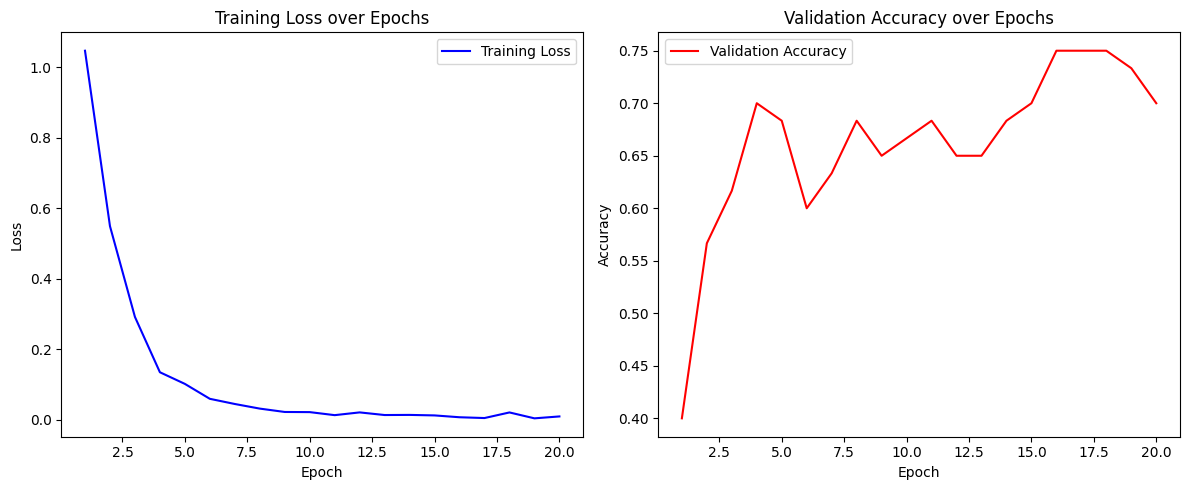

In [76]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Validation Accuracy: {val_acc:.4f}")

print("Training complete.")

# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Integrating Learning Rate Scheduling